In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import warnings
warnings.filterwarnings(action = 'ignore')
plt.style.use('seaborn')

In [13]:
def dataLoader(path:str, thresh:int = 0.2)->pd.DataFrame:
    '''
    Load the data. Drop cols with null threshold more than thresh param.
    '''
    data = pd.read_csv(path)
    data = data.drop('Id', axis = 1)
    null_cols = data.isnull().sum()[data.isnull().sum()/len(data) > thresh]
    null_cols_list = null_cols.index
    data.drop(null_cols_list, axis = 1, inplace = True)
    data.dropna(inplace = True)
    print(f'data shape: {data.shape}')
    return data

In [14]:
data = dataLoader('train.csv', 0.15)
data.head()

data shape: (1338, 74)


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [15]:
def dataSeg(data:pd.DataFrame)->pd.DataFrame:
    '''
    Separates the numerical data from cat data.  
    y = Target Series
    num = DataFrame with only numerical values
    cat = DataFrame with only object values
    '''
    input_data = data.drop('SalePrice', axis = 1)
    y  = data['SalePrice']
    num = input_data.select_dtypes(exclude = 'object')
    cat = input_data.select_dtypes(include = 'object')
    
    '''
    Seperates the numerical data suitable for standardization, numerical ordinal data and year data for Target Encoding
    int_data = DataFrame for standardization(columns which had nunique > 50)
    ordinal_data = DataFrame containing ordinal columns(columns which had nunique < 50)
    int_year_data = DataFrame containing year columns 
    '''
    int_data_temp = num.nunique()[(num.nunique()>50) & (~num.columns.str.match('Year|Yr|[A-za-z]+Yr'))]
    ordinal_data_temp = num.nunique()[num.nunique()<50]
    int_year_data_temp = num.nunique()[num.columns.str.match('Year|Yr|[A-za-z]+Yr')]#.astype(str)
    int_data = num.loc[:, int_data_temp.index]
    ordinal_data = num.loc[:, ordinal_data_temp.index]
    int_year_data = num.loc[:, int_year_data_temp.index]
    
    '''
    Seperates the categorical data suitable for OHE and Traget Encoding
    cat_data_ohe = DataFrame containing object data for OHE(columns which had nunique < 10)
    cat_data_tc = DataFrame containing object data for TargetEncoding(columns which had nunique > 10)
    '''
    cat_cols_ohe_temp = cat.nunique()[cat.nunique()<10]
    cat_cols_tc_temp = cat.nunique()[cat.nunique()>10]
    cat_data_ohe = cat.loc[:, cat_cols_ohe_temp.index]
    cat_data_tc = cat.loc[:, cat_cols_tc_temp.index]
    
    
    return y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc

In [16]:
y, int_data, ordinal_data, int_year_data, cat_data_ohe, cat_data_tc = dataSeg(data)
int_data.shape

(1338, 14)

In [17]:
def removeOutliers(data: pd.DataFrame)->pd.DataFrame:
    
    iqr = data.apply(lambda x: stats.iqr(x))
    q3 = data.apply(lambda x: x.quantile(0.75))
    q1 = data.apply(lambda x: x.quantile(0.25))
    ul = q3 + 1.5 * iqr
    ll = q1 - 1.5 * iqr
    try:
        assert len(ul) == len(ll)
        new_data = data.apply(lambda x: [x.median() if (i > ul[x.name] or i < ll[x.name]) else i for i in x])
    except AssertionError:
        print(f'Columns are mismatching: {ul}, {ll}')
    new_data1 = new_data.drop(new_data.sum()[new_data.sum() == 0].index, axis = 1)
    new_data_std = (new_data1 - new_data1.mean())/new_data1.std()
    return new_data_std

In [18]:
new_data_std = removeOutliers(int_data)
new_data_std.head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF
0,-0.335239,1.119230,0.592536,-1.015962,-0.627452,-0.875256,1.146109,0.483464,0.377844,-0.806724,0.547384
1,0.042933,-0.627961,1.232478,-0.678103,0.549352,0.305548,-0.812224,-0.538437,-0.161709,1.912642,-0.841937
2,0.585528,0.816146,0.074936,-0.299903,-0.441946,-0.689120,1.173627,0.656822,0.745720,-0.806724,0.114645
3,0.026491,-0.627961,-0.560301,-0.032642,-0.917306,-0.569876,0.921382,0.499431,0.954184,-0.806724,-0.044786
4,1.575353,2.492024,0.472547,-0.158708,0.210224,-0.034733,1.602442,1.596607,2.143652,0.945351,1.071227


In [19]:
from category_encoders import TargetEncoder
def encoding(int_year_data:pd.DataFrame, cat_data_ohe:pd.DataFrame, cat_data_tc:pd.DataFrame)->pd.DataFrame:
    
    '''
    after_ohe_cat = Categoriacal columns OHE(nunique < 10)
    '''
    after_ohe_cat = pd.get_dummies(cat_data_ohe, drop_first = True)
    
    '''
    after_tc_year_std = Year column target encoded and standardized
    after_tc_cat_std = Categorical column(nunique > 10) target encoded and standardized
    '''
    encoder = TargetEncoder()
    after_tc_year_temp = encoder.fit_transform(int_year_data.astype(str), y)
    after_tc_cat_temp = encoder.fit_transform(cat_data_tc, y)
    after_tc_year_std = (after_tc_year_temp - after_tc_year_temp.mean()) / after_tc_year_temp.std()
    after_tc_cat_std = (after_tc_cat_temp - after_tc_cat_temp.mean()) / after_tc_cat_temp.std()
    
    
    return after_ohe_cat, after_tc_year_std, after_tc_cat_std

In [20]:
after_ohe_cat, after_tc_year, after_tc_cat = encoding(int_year_data, cat_data_ohe, cat_data_tc)
after_ohe_cat.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [21]:
def feature_concat(*args):
    features_for_model = pd.concat(args, axis = 1)
    return features_for_model

In [28]:
feature = feature_concat(new_data_std, ordinal_data, after_ohe_cat, after_tc_year, after_tc_cat)
feature

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,...,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,Neighborhood,Exterior1st,Exterior2nd
0,-0.335239,1.119230,0.592536,-1.015962,-0.627452,-0.875256,1.146109,0.483464,0.377844,-0.806724,...,0,1,0,1.017682,0.285627,1.007495,-0.894258,0.229513,1.017326,1.065322
1,0.042933,-0.627961,1.232478,-0.678103,0.549352,0.305548,-0.812224,-0.538437,-0.161709,1.912642,...,0,1,0,-0.833132,-0.707836,-0.900593,1.602982,0.288626,-1.147664,-1.145377
2,0.585528,0.816146,0.074936,-0.299903,-0.441946,-0.689120,1.173627,0.656822,0.745720,-0.806724,...,0,1,0,0.715241,0.746128,0.743828,-0.894258,0.229513,1.017326,1.065322
3,0.026491,-0.627961,-0.560301,-0.032642,-0.917306,-0.569876,0.921382,0.499431,0.954184,-0.806724,...,0,0,0,-0.620534,-0.893369,0.330481,0.281754,0.441819,-1.028007,-0.391987
4,1.575353,2.492024,0.472547,-0.158708,0.210224,-0.034733,1.602442,1.596607,2.143652,0.945351,...,0,1,0,0.258252,-0.055325,0.166660,-0.894258,2.566628,1.017326,1.065322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.510513,-0.627961,-1.068490,1.008669,-0.346295,-0.593143,0.779208,0.339759,-0.161709,-0.806724,...,0,1,0,0.274293,-0.055325,0.063054,1.602982,0.114639,1.017326,1.065322
1456,1.218556,0.432834,0.790165,0.090904,1.360941,2.664247,-0.812224,1.311478,0.083542,2.378037,...,0,1,0,-0.460738,-0.079708,-0.623736,-1.271322,0.040874,-0.275324,-0.451393
1457,-0.140562,-0.627961,-0.421490,0.817048,0.230514,0.090327,1.829462,1.920513,-1.437015,-0.806724,...,0,1,0,-0.885540,1.345796,-0.804645,-1.271322,0.441819,2.071855,2.048289
1458,0.081408,-0.627961,-0.953207,-1.394162,0.016022,-0.229595,-0.812224,-0.958147,-1.510590,2.533168,...,0,1,0,-0.857632,0.685263,-1.031467,-1.271322,-0.742925,-1.147664,-1.145377


### Log Scale

In [23]:
y = np.log1p(y)
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

### Model

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer, mean_absolute_error
def PolynomialRegression(degree=1, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

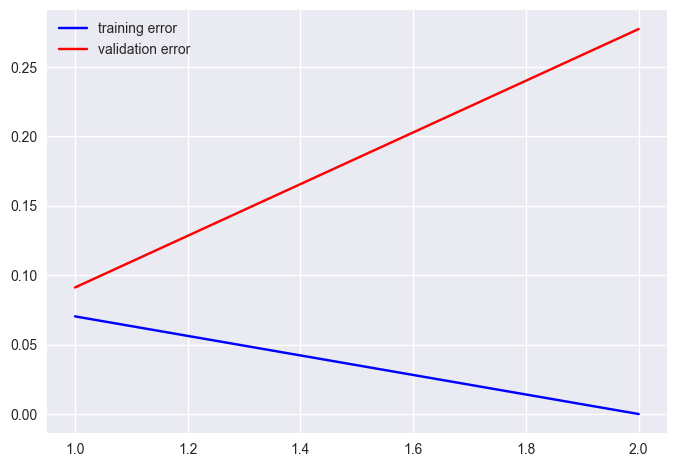

In [25]:
import numpy as np
scorer = make_scorer(mean_absolute_error)
degree = np.arange(1,3)
train_err, val_err = validation_curve(estimator = PolynomialRegression(), X = feature, y = y,
                                      param_name='polynomialfeatures__degree', 
                                      param_range=degree, cv=3, scoring = scorer)
plt.plot(degree, np.mean(train_err,1), color='blue', label='training error')
plt.plot(degree, np.mean(val_err,1), color='red', label='validation error')
plt.legend(loc='best');

In [26]:
X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size = 0.2, shuffle = False)
X_train

,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,...,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,Neighborhood,Exterior1st,Exterior2nd
0,-0.335239,1.119230,0.592536,-1.015962,-0.627452,-0.875256,1.146109,0.483464,0.377844,-0.806724,...,0,1,0,1.017682,0.285627,1.007495,-0.894258,0.229513,1.017326,1.065322
1,0.042933,-0.627961,1.232478,-0.678103,0.549352,0.305548,-0.812224,-0.538437,-0.161709,1.912642,...,0,1,0,-0.833132,-0.707836,-0.900593,1.602982,0.288626,-1.147664,-1.145377
2,0.585528,0.816146,0.074936,-0.299903,-0.441946,-0.689120,1.173627,0.656822,0.745720,-0.806724,...,0,1,0,0.715241,0.746128,0.743828,-0.894258,0.229513,1.017326,1.065322
3,0.026491,-0.627961,-0.560301,-0.032642,-0.917306,-0.569876,0.921382,0.499431,0.954184,-0.806724,...,0,0,0,-0.620534,-0.893369,0.330481,0.281754,0.441819,-1.028007,-0.391987
4,1.575353,2.492024,0.472547,-0.158708,0.210224,-0.034733,1.602442,1.596607,2.143652,0.945351,...,0,1,0,0.258252,-0.055325,0.166660,-0.894258,2.566628,1.017326,1.065322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,2.199173,-0.627961,0.531365,-0.665496,0.833408,0.799973,-0.812224,-0.150662,0.623095,0.726341,...,0,1,0,-0.460738,-0.357441,-0.623736,1.602982,0.288626,-0.275324,-0.451393
1165,0.023532,1.761056,-1.068490,2.392881,1.245000,1.003560,-0.812224,0.009010,0.966446,-0.806724,...,0,0,1,1.024752,1.566825,1.976517,-0.405710,2.471586,1.017326,1.065322
1166,0.330673,0.013864,-1.068490,-0.161230,1.801518,1.561969,-0.812224,0.446968,1.775775,0.653338,...,0,1,0,2.911312,2.432992,2.776058,-1.271322,0.229513,1.017326,1.065322
1167,0.454648,-0.627961,0.780754,-0.957971,-0.328903,-0.575693,0.820485,0.394504,-0.088134,-0.806724,...,0,1,0,0.258252,-0.055325,0.166660,0.281754,0.114639,1.017326,1.065322


In [29]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [30]:
print(reg.coef_)
print(reg.intercept_)

[ 1.66184730e-02 -8.85978779e-03  2.09998169e-02 -2.84961215e-03
  2.37769995e-02  5.18548042e-02  4.09948982e-02  4.19582106e-02
  5.18897931e-04  2.98282221e-03  5.15749668e-03 -7.74147003e-04
  4.88652651e-02  3.74624962e-02 -5.94001039e-05  3.17868371e-02
  2.17979770e-02  4.76249055e-02  2.22354259e-02 -1.58470776e-02
 -1.26484195e-01  2.19990563e-02  2.77334999e-02  3.33047300e-02
  8.31758697e-05  2.34168493e-04  1.59166472e-07 -1.49728188e-03
 -3.46067636e-03  5.05878000e-01  4.60886531e-01  4.52353975e-01
  4.14168826e-01 -1.15338097e-02  2.13823893e-02  8.76667980e-02
  2.41564729e-03  1.53593490e-02  2.16830920e-02  1.59943677e-03
 -3.09876987e-01  3.48956809e-02 -3.44194094e-02  4.54719735e-03
 -1.10940729e-02  4.11809702e-02 -4.81723664e-02  4.73322120e-02
  8.76607840e-02  3.45379497e-02  1.07485178e-01 -1.30944858e-02
  7.64009975e-02  2.57123253e-02  4.81394412e-02 -1.25955963e-01
 -6.25672422e-02  9.80104670e-02 -5.59951784e-01 -5.09314813e-15
 -1.22388780e-01 -2.61534

In [32]:
input_vals = X_train.iloc[0,:].values
wght = np.array(reg.coef_)

In [33]:
coef_mul = input_vals * wght
pred_val = coef_mul.sum() + reg.intercept_

In [34]:
y_pred =reg.predict(X_test)
y_pred

array([13.11839491, 12.01208066, 11.97872929, 12.03596373, 12.37854534,
       12.63366986, 11.72104679, 11.64475399, 11.78084583, 12.29992527,
       12.58868032, 12.75457861, 11.88803787, 12.24010715, 11.79526752,
       11.62625951, 12.55631092, 12.12031893, 12.12485439, 12.07194639,
       12.01524888, 11.79678757, 11.91912249, 11.8688559 , 12.03093104,
       12.36338976, 11.91103745, 12.0420478 , 11.83882166, 11.46100772,
       12.14235829, 11.7954213 , 12.17008251, 11.95882542, 12.29925751,
       11.72822139, 12.26195145, 11.85230584, 12.58358186, 12.16801714,
       12.24588428, 11.48351481, 11.76854757, 11.72692028, 11.61019273,
       12.40187335, 11.56538933, 11.68274031, 11.98591864, 11.70181138,
       12.25011418, 11.89477508, 12.35627118, 11.91432204, 12.81213471,
       11.88288998, 12.33850251, 11.8813481 , 11.80619957, 11.8456174 ,
       12.1287126 , 12.24741021, 11.81021498, 12.4323347 , 12.23639992,
       12.42733661, 12.12884729, 12.22813559, 12.195253  , 12.20

In [35]:
from sklearn.metrics import  r2_score
score = r2_score(y_pred, y_test)
print(score)

0.8290843281648479


In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
score = cross_val_score(reg, feature, y, cv = 5)
score.mean()

0.8588099669099503

In [42]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

In [51]:
ridge_cv_model = RidgeCV(alphas = np.arange(1,30,1))
ridge_cv_model.fit(feature, y)
ridge_cv_model.alpha_

26

In [54]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha = 26)
ridge_model.fit(feature, y)
ridge_model.coef_

array([ 1.72639119e-02, -6.84300142e-03,  3.35799585e-02,  3.47712376e-03,
        2.90042877e-02,  4.26635536e-02,  3.50263096e-02,  4.08822805e-02,
        6.37292666e-03,  5.54619143e-03,  9.14673138e-03, -4.50088392e-04,
        6.02430976e-02,  4.70947916e-02,  6.71750223e-06,  2.25170789e-02,
        3.10578344e-03,  3.33029377e-02,  3.17813760e-02, -1.12439212e-03,
       -4.84879141e-02,  1.62854268e-02,  3.01170572e-02,  3.70511804e-02,
        1.24304090e-04,  2.19303426e-04, -1.38133429e-06, -1.06337246e-03,
       -2.86444676e-03,  5.64350422e-02,  8.70484065e-03,  2.77791368e-02,
       -1.06919648e-03,  2.03756563e-02,  1.99733822e-02, -1.27869230e-02,
       -5.86531431e-03,  2.01287015e-02,  1.13772491e-02,  8.40634178e-03,
       -8.11276416e-03,  2.76622650e-02, -2.13189791e-02, -7.86086952e-03,
       -8.20528188e-03,  2.32764031e-02,  4.33466836e-03, -1.02578769e-02,
        4.04830690e-02,  1.21362042e-03,  1.43228352e-02, -1.89444535e-02,
        1.29178152e-02, -

In [58]:
ridge_score = cross_val_score(ridge_model, feature, y, cv = 5)
ridge_score.mean()

0.8874496281954061

In [65]:
def Polynomial_Regression(degree=1, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

In [66]:
ridge_polynimial_score = cross_val_score(Polynomial_Regression(), feature, y, cv = 3)
ridge_polynimial_score

array([0.90529387, 0.8747601 , 0.87198071])